In [106]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Load preprocessed data
train_file = 'preprocessed_train.csv'
test_file = 'preprocessed_test.csv'

train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

# Ensure all columns are numeric
train_data_numeric = train_data.apply(pd.to_numeric, errors='coerce')
test_data_numeric = test_data.apply(pd.to_numeric, errors='coerce')

# Handle missing values
train_data_numeric = train_data_numeric.fillna(0)
test_data_numeric = test_data_numeric.fillna(0)

# Align features between train and test data
target_column = 'Lunch Calories'  # Replace with the correct column name

# Identify training features (excluding the target column)
train_columns = train_data_numeric.drop(columns=[target_column]).columns
test_columns = test_data_numeric.columns

# Add missing columns to test data with default value 0
for col in train_columns:
    if col not in test_columns:
        test_data_numeric[col] = 0

# Remove extra columns from test data
test_data_numeric = test_data_numeric[train_columns]

# Extract labels and features
train_features = train_data_numeric[train_columns].values.astype(np.float32)
train_labels = train_data_numeric[target_column].values.astype(np.float32)
test_features = test_data_numeric.values.astype(np.float32)

# Custom Dataset class for PyTorch
class MultiModalDataset(Dataset):
    def __init__(self, features, labels=None):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = None if labels is None else torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        if self.labels is not None:
            return self.features[idx], self.labels[idx]
        return self.features[idx]

# Create DataLoader for train and test datasets
train_dataset = MultiModalDataset(train_features, train_labels)
test_dataset = MultiModalDataset(test_features)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Data Loaders Created Successfully!")

# Validate DataLoader outputs
for batch_features, batch_labels in train_loader:
    print("Batch Features Shape:", batch_features.shape)
    print("Batch Labels Shape:", batch_labels.shape)
    break

# Validate test data
for batch_features in test_loader:
    print("Test Batch Features Shape:", batch_features.shape)
    break


Data Loaders Created Successfully!
Batch Features Shape: torch.Size([32, 12353])
Batch Labels Shape: torch.Size([32])
Test Batch Features Shape: torch.Size([32, 12353])


Epoch 1/200, Loss: 0.6046
Epoch 2/200, Loss: 0.3813
Epoch 3/200, Loss: 0.3493
Epoch 4/200, Loss: 0.3476
Epoch 5/200, Loss: 0.3308
Epoch 6/200, Loss: 0.3585
Epoch 7/200, Loss: 0.3420
Epoch 8/200, Loss: 0.3472
Epoch 9/200, Loss: 0.3138
Epoch 10/200, Loss: 0.3678
Epoch 11/200, Loss: 0.3499
Epoch 12/200, Loss: 0.3303
Epoch 13/200, Loss: 0.3366
Epoch 14/200, Loss: 0.3401
Epoch 15/200, Loss: 0.3287
Epoch 16/200, Loss: 0.3084
Epoch 17/200, Loss: 0.2961
Epoch 18/200, Loss: 0.2962
Epoch 19/200, Loss: 0.3030
Epoch 20/200, Loss: 0.3179
Epoch 21/200, Loss: 0.3180
Epoch 22/200, Loss: 0.3284
Epoch 23/200, Loss: 0.3289
Epoch 24/200, Loss: 0.2919
Epoch 25/200, Loss: 0.2859
Epoch 26/200, Loss: 0.2856
Epoch 27/200, Loss: 0.2846
Epoch 28/200, Loss: 0.3024
Epoch 29/200, Loss: 0.2798
Epoch 30/200, Loss: 0.3442
Epoch 31/200, Loss: 0.2862
Epoch 32/200, Loss: 0.2735
Epoch 33/200, Loss: 0.3652
Epoch 34/200, Loss: 0.3429
Epoch 35/200, Loss: 0.3236
Epoch 36/200, Loss: 0.2909
Epoch 37/200, Loss: 0.2692
Epoch 38/2

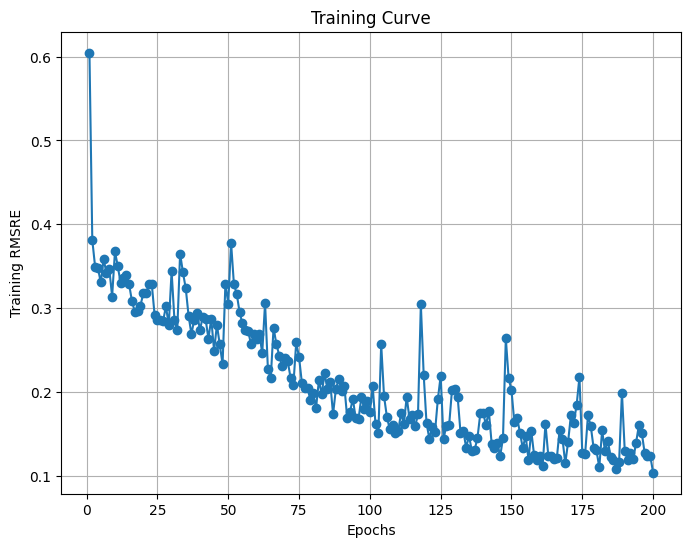

In [108]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the MultiModal Model
class MultiModalModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim):
        super(MultiModalModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, embedding_dim)
        self.fc3 = nn.Linear(embedding_dim, 1)  # Output a single value

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Set input_dim to match the aligned features
input_dim = train_features.shape[1]  # Number of features in the input
hidden_dim = 128  # Size of the hidden layer
embedding_dim = 64  # Size of the embedding layer
learning_rate = 0.001  # Learning rate
num_epochs = 200  # Number of training epochs

# Instantiate the model
model = MultiModalModel(input_dim, hidden_dim, embedding_dim)

# Define RMSRE as the loss function
def rmsre(y_pred, y_true):
    epsilon = 1e-8  # Small value to avoid division by zero
    loss = torch.sqrt(torch.mean(((y_true - y_pred) / (y_true + epsilon)) ** 2))
    return loss

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for features, labels in train_loader:
        optimizer.zero_grad()
        predictions = model(features).squeeze()
        # Ensure labels are positive to avoid issues with RMSRE
        labels = torch.clamp(labels, min=1e-8)
        loss = rmsre(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_losses[-1]:.4f}")

# Plot the training curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Training RMSRE')
plt.title('Training Curve')
plt.grid()
plt.show()


In [109]:
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Split the training data into train and validation sets
train_features_split, val_features_split, train_labels_split, val_labels_split = train_test_split(
    train_features, train_labels, test_size=0.2, random_state=42
)

# Convert to PyTorch Datasets and DataLoaders
train_dataset_split = MultiModalDataset(train_features_split, train_labels_split)
val_dataset_split = MultiModalDataset(val_features_split, val_labels_split)

train_loader_split = DataLoader(train_dataset_split, batch_size=32, shuffle=True)
val_loader_split = DataLoader(val_dataset_split, batch_size=32, shuffle=False)

# Define a function to train and evaluate the model
def train_and_evaluate_model(hidden_dim, learning_rate, epochs):
    model = MultiModalModel(input_dim, hidden_dim, embedding_dim)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = rmsre

    best_val_loss = float("inf")
    best_model = None

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for features, labels in train_loader_split:
            optimizer.zero_grad()
            predictions = model(features).squeeze()
            loss = loss_fn(predictions, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features, labels in val_loader_split:
                predictions = model(features).squeeze()
                loss = loss_fn(predictions, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader_split)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = model
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader_split):.4f}, Val Loss: {avg_val_loss:.4f}")
    
    return best_model, best_val_loss

# Hyperparameter grid
hidden_dims = [64, 128, 256]
learning_rates = [0.001, 0.0005]
epochs = 500

# Fine-tune hyperparameters
best_model = None
best_loss = float("inf")
for hidden_dim in hidden_dims:
    for lr in learning_rates:
        print(f"Training with hidden_dim={hidden_dim}, lr={lr}")
        model, val_loss = train_and_evaluate_model(hidden_dim, lr, epochs)
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model

print(f"Best Model Loss: {best_loss}")


Training with hidden_dim=64, lr=0.001
Epoch 1/500, Train Loss: 0.5337, Val Loss: 0.4873
Epoch 2/500, Train Loss: 0.4168, Val Loss: 0.4618
Epoch 3/500, Train Loss: 0.3625, Val Loss: 0.4783
Epoch 4/500, Train Loss: 0.3561, Val Loss: 0.4649
Epoch 5/500, Train Loss: 0.3641, Val Loss: 0.4619
Epoch 6/500, Train Loss: 0.3407, Val Loss: 0.4536
Epoch 7/500, Train Loss: 0.3259, Val Loss: 0.4748
Epoch 8/500, Train Loss: 0.3792, Val Loss: 0.5036
Epoch 9/500, Train Loss: 0.3691, Val Loss: 0.4426
Epoch 10/500, Train Loss: 0.3426, Val Loss: 0.4602
Epoch 11/500, Train Loss: 0.3583, Val Loss: 0.4521
Epoch 12/500, Train Loss: 0.3370, Val Loss: 0.4502
Epoch 13/500, Train Loss: 0.3247, Val Loss: 0.4533
Epoch 14/500, Train Loss: 0.3082, Val Loss: 0.4579
Epoch 15/500, Train Loss: 0.3104, Val Loss: 0.4620
Epoch 16/500, Train Loss: 0.3370, Val Loss: 0.4685
Epoch 17/500, Train Loss: 0.2769, Val Loss: 0.4824
Epoch 18/500, Train Loss: 0.3013, Val Loss: 0.5268
Epoch 19/500, Train Loss: 0.3570, Val Loss: 0.4849
Ep

In [110]:
# Generate predictions on the test set
best_model.eval()
predictions = []

with torch.no_grad():
    for features in test_loader:
        preds = best_model(features).squeeze()
        predictions.extend(preds.numpy())

# Ensure predictions are positive (e.g., clip negative values to 0)
predictions = np.maximum(predictions, 0)

# Prepare Kaggle submission file
submission = pd.DataFrame({
    "row_id": np.arange(len(predictions)),  # row_id starts from 0
    "label": predictions  # Predictions as the label column
})

# Save to CSV
submission_file = "kaggle_submission.csv"
submission.to_csv(submission_file, index=False)

print(f"Kaggle submission file saved as {submission_file}")


Kaggle submission file saved as kaggle_submission.csv


In [98]:
print("Train Features Shape:", train_features.shape)
print("Test Features Shape:", test_features.shape)


Train Features Shape: (324, 12353)
Test Features Shape: (73, 12350)
